In [7]:
# need to install ipympl and restart jupyter notebook
%matplotlib widget

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import multiprocessing as mp
from test import sample_now

def main(conf):    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    im = plt.imshow(np.random.rand(10,10), animated=True)  # Initialize with a random image
    plt.subplot(1, 2, 2)
    gr = plt.plot(np.random.rand(10), marker='x')
    scatter = plt.scatter(np.random.rand(10), np.random.rand(10))

    queue = mp.Queue()

    times = []

    def callback(args):
        while not queue.empty():
            data = queue.get_nowait()
            if isinstance(data, tuple):
                if isinstance(data[0], str):
                    if data[0] == 'times':                        
                        times.extend(data[1])
                        data_arr = np.array(data[1])
                        x = np.arange(data_arr.shape[0])
                        gr[0].set_ydata(data_arr)
                        gr[0].set_xdata(x)
                        gr[0].axes.set_xlim(0, data_arr.shape[0])
                        gr[0].axes.set_ylim(np.min(data_arr), np.max(data_arr))
                    else:
                        plt.suptitle(data[1])
                else:
                    idx = data[0]
                    data = data[1]
                    data = (data - np.min(data))/(np.max(data) - np.min(data))
                    if times is not None:
                        scatter.set_offsets(np.c_[idx, times[idx]])
                    im.set_array(data)  # Update the image                
        return im, gr, scatter

    ani = animation.FuncAnimation(fig, callback, frames=range(1000), interval=1000, blit=False)

    p = mp.Process(target=sample_now, args=(conf, queue))
    p.start()

    plt.show()
    return p, ani

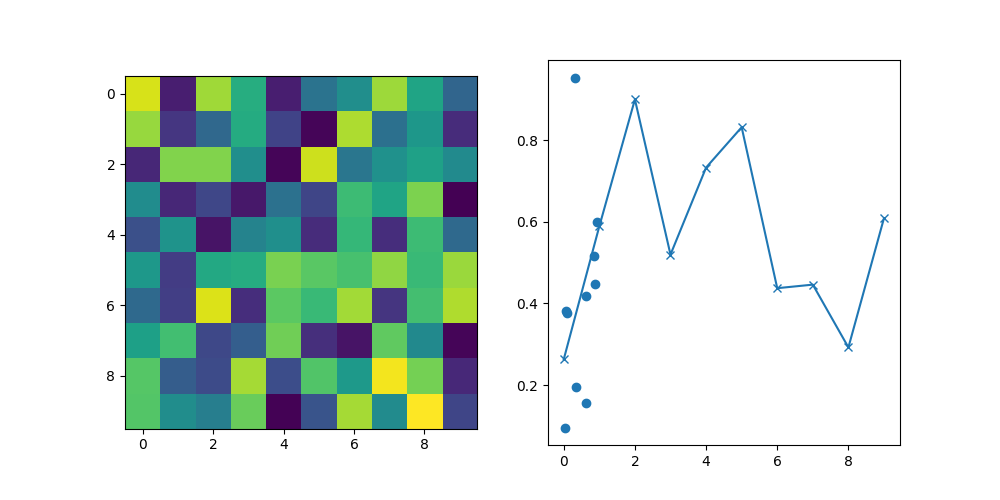

In [16]:
import conf_mgt
from utils import yamlread
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
p, ani = main(conf_arg)

In [18]:
p.terminate()
ani.event_source.stop()

### Resizing images

In [8]:
import cv2
types = 'gt_keep_masks/genhalf'
types2 = 'gt_keep_masks/genhalf3'
# types = 'gts/inet256'
for i in range(8):
    img = cv2.imread(f'data/datasets/{types}/00000{i}.png', cv2.IMREAD_UNCHANGED)
    
    print('Original Dimensions : ',img.shape)
    
    width = int(img.shape[1] * 1 / 4)
    height = int(img.shape[0] * 1 / 4)
    dim = (width, height)
    
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    print('Resized Dimensions : ',resized.shape)

    cv2.imwrite(f'data/datasets/{types2}/00000{i}.png', resized)
    
    # cv2.imshow("Resized image", resized)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)


# Methods

Paper inspired from [Open AI guided diffusion](https://arxiv.org/pdf/2105.05233.pdf).

### Diffusion model



### Metrics

#### User study

#### LPIPS / FID

## Configuration

In [ ]:
conf_path = 'confs/face_example.yml'
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread(conf_path))

## Resampling schedule

Implement resampling and as a function of the size of the hidden mask

In [ ]:
# start resampling from middle and merge data lately

## Diffusion process step by step

Only 25 passes with classifierg guidance
not working to scheduler 0, 10, ... 250
nor less than 250

## Classifier

Ideas to optimize

- u8 weights
- smaller resolution 64x64

In [ ]:
!pip install lpips

In [12]:
import lpips
import torch as th
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# read png image
file_img0 = 'log/face_example/inpainted/000000.png'
file_img1 = 'log/face_example/inpainted/000000 copy.png'
file_img1 = 'log/face_example/inpainted/000000 copy 2.png'
file_img1 = 'log/face_example/gt/000000.png'
img0 = cv2.imread(file_img0, cv2.IMREAD_UNCHANGED)
img1 = cv2.imread(file_img1, cv2.IMREAD_UNCHANGED)

img0 = th.from_numpy(img0).permute(2, 0, 1).unsqueeze(0).float() / 255
img1 = th.from_numpy(img1).permute(2, 0, 1).unsqueeze(0).float() / 255

d = loss_fn_alex(img0, img1)
print(d)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\PolletStars\Anaconda3\envs\repaint\lib\site-packages\lpips\weights\v0.1\alex.pth
tensor([[[[0.1664]]]], grad_fn=<AddBackward0>)


## Going further

- diffusion model inversion (bigprior) ? DDIM Song and al ?

https://www.youtube.com/watch?v=lvv4N2nf-HU openAI Glide